<a href="https://colab.research.google.com/github/dganguli/tlon/blob/master/test_classification_performance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import time
import torch
import torch.nn.functional as F
import umap

import matplotlib.pyplot as plt
from torch.autograd import Variable
from torchvision.utils import make_grid

print("torch cuda is available: {}".format(torch.cuda.is_available()))
print("number of gpus: {}".format(torch.cuda.device_count()))
print("1st gpu is of type: {}".format(torch.cuda.get_device_name(0)))

torch cuda is available: True
number of gpus: 1
1st gpu is of type: Tesla P4


In [2]:
import sys
! git clone https://github.com/dganguli/tlon.git
%cd /content/tlon/
! git pull
sys.path.append('/content/tlon')

Cloning into 'tlon'...
remote: Enumerating objects: 131, done.
remote: Counting objects: 100% (131/131), done.
remote: Compressing objects: 100% (94/94), done.
remote: Total 131 (delta 70), reused 84 (delta 37), pack-reused 0
Receiving objects: 100% (131/131), 15.80 MiB | 33.64 MiB/s, done.
Resolving deltas: 100% (70/70), done.
/content/tlon
Already up to date.


In [0]:
from cnn import CNN

cnn_real = CNN().from_save_dict('/content/tlon/trained_models/cnn_real.pth')
cnn_synt = CNN().from_save_dict('/content/tlon/trained_models/cnn_synt.pth')

In [4]:
from data import load_mnist, load_synthetic_mnist

_, test_loader_synt = load_synthetic_mnist('/content/tlon/trained_models/generator.pth')
_, test_loader_real = load_mnist('/tmp')


Extracting /tmp/MNIST/raw/train-images-idx3-ubyte.gz to /tmp/MNIST/raw



Extracting /tmp/MNIST/raw/train-labels-idx1-ubyte.gz to /tmp/MNIST/raw



Extracting /tmp/MNIST/raw/t10k-images-idx3-ubyte.gz to /tmp/MNIST/raw



Extracting /tmp/MNIST/raw/t10k-labels-idx1-ubyte.gz to /tmp/MNIST/raw
Processing...
Done!


In [0]:
def compute_accuracy(model, test_loader):
  model.cuda()

  correct = 0
  with torch.no_grad():
      for data, target in test_loader:
          data = data.cuda()
          target = target.cuda()
          output = model(data)
          pred = output.data.max(1, keepdim=True)[1]
          correct += pred.eq(target.data.view_as(pred)).sum()

  accuracy = 100.* correct/ len(test_loader.dataset)
  
  print(accuracy.item())
  return accuracy.item()

def sample_images(dataset_loader, num_imgs, nrows):
  batch = next(iter(dataset_loader))
  img, _ = batch
  img = img[0:num_imgs,:]
  res = make_grid(img, nrow=nrows)
  res = np.transpose(res.cpu().data.numpy(), (1,2,0))
  return res

def fc1_layer_activation(model, x):
    model.eval()
    layers = dict(model.named_children())
    x = F.relu(F.max_pool2d(layers['conv1'](x), 2))
    x = F.relu(F.max_pool2d(layers['conv2'](x), 2))
    x = x.view(-1, 320)
    x = F.relu(layers['fc1'](x))
    # x = layers['fc2'](x)
    # x = F.log_softmax(x, 1)
    return x

In [13]:
rr = compute_accuracy(cnn_real, test_loader_real)
rs = compute_accuracy(cnn_real, test_loader_synt)
sr = compute_accuracy(cnn_synt, test_loader_real)
ss = compute_accuracy(cnn_synt, test_loader_synt);

96.94999694824219
97.93000030517578
94.0199966430664
98.13999938964844


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1, 'Synthetic Data')

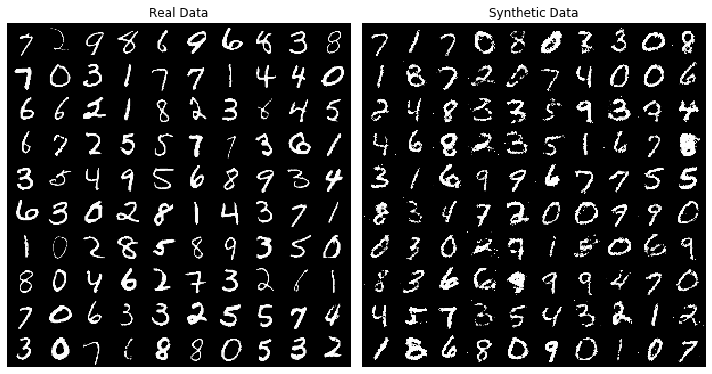

In [14]:
num_imgs = 100
nrows = 10

fig = plt.figure(figsize=(10,10))
plt.subplot(121)
plt.imshow(sample_images(test_loader_real, num_imgs, nrows), interpolation='nearest')
plt.title('Real Data')
plt.axis('off')

plt.subplot(122)
plt.imshow(sample_images(test_loader_synt, num_imgs, nrows), interpolation='nearest')
plt.axis('off')

plt.tight_layout()
plt.title('Synthetic Data')

In [0]:
original_model = cnn_real
dataset_loader = test_loader_real

batch, targets = next(iter(dataset_loader))
targets = targets.data.cpu().numpy()

In [0]:
def get_embedding(model, dataset_loader):
  batch, targets = next(iter(dataset_loader))
  targets = targets.data.cpu().numpy()
  
  out = fc1_layer_activation(cnn_synt, batch.cuda())
  out = out.data.cpu().numpy()
  
  embedding = umap.UMAP().fit_transform(out)

  res = pd.DataFrame({'x': embedding[:,0], 
              'y': embedding[:,1],
              'digit': targets})

  res.digit = pd.Categorical(res.digit)

  return res


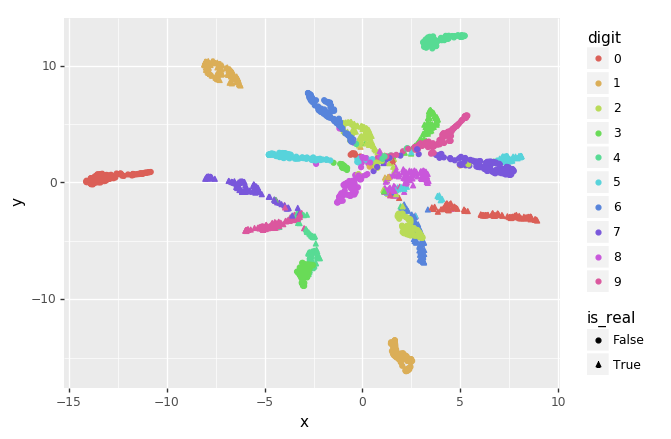

<ggplot: (-9223363278586403363)>

In [17]:
e_real = get_embedding(cnn_real, test_loader_real)
e_synt = get_embedding(cnn_real, test_loader_synt)

e_real['is_real'] = True
e_synt['is_real'] = False
e = pd.concat([e_real, e_synt])

from plotnine import *

(ggplot(e) +
 aes(x='x', y='y', color='digit', shape='is_real') +
 geom_point()
)


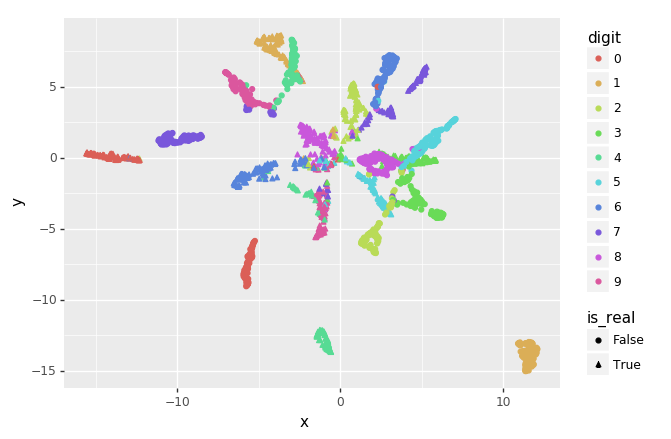

<ggplot: (-9223363278586451982)>

In [18]:
e_real = get_embedding(cnn_synt, test_loader_real)
e_synt = get_embedding(cnn_synt, test_loader_synt)

e_real['is_real'] = True
e_synt['is_real'] = False
e = pd.concat([e_real, e_synt])

from plotnine import *

(ggplot(e) +
 aes(x='x', y='y', color='digit', shape='is_real') + 
 geom_point()
)
